In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch
from google.colab import drive
import os 
import os.path
import cv2
import re
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PATH = "drive/My Drive/Colab Notebooks/NN/data"
# PATH = "./generated"
pattern = 'not'

height = 64
width = 64

images = np.empty((0, height, width))
labels = np.empty((0,))

for root, dirs, files in os.walk(PATH):
  for dir in dirs: 
      if re.search('hq_unit',dir):
        label = 1
      else:
        label = 0
      sub_path = os.path.join(root, dir)
      image_urls = [os.path.join(sub_path, image_name) for image_name in os.listdir(sub_path)]


      images_trans = np.array([cv2.resize(cv2.imread(image_url, cv2.IMREAD_GRAYSCALE), (width, height), interpolation=cv2.INTER_AREA) for image_url in image_urls])
      labels_trans = np.repeat(a = label, repeats = images_trans.shape[0])

      images = np.concatenate((images, images_trans), axis=0)
      labels = np.concatenate((labels, labels_trans), axis=0)

images = np.expand_dims(images, axis=1)
# images = np.delete(images, 0)
# labels = np.delete(labels, 0)

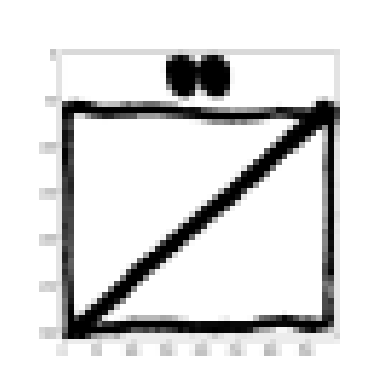

In [3]:
plt.imshow(images[0][0], cmap='gray')
plt.axis('off') 
plt.show()

In [4]:
images_tensor = torch.from_numpy(images)

In [5]:
rotation_angles = 20
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(rotation_angles),
    transforms.ToTensor()
])

In [6]:
images_augm = np.array([np.array(transform(image_tensor))*255 for image_tensor in images_tensor])
labels_augm = np.repeat(labels, repeats=1)

In [7]:
images_final = np.concatenate((images, images_augm), axis=0)
labels_final = np.concatenate((labels, labels_augm), axis=0)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images_final, labels_final, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# convert data to PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

# create PyTorch datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# create PyTorch dataloaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [9]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 50, kernel_size=2, stride=1)
        self.bn1 = nn.BatchNorm2d(50)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(50, 50, kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm2d(50)
        self.relu2 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.bn3 = nn.BatchNorm2d(50)
        self.relu3 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(11250, 100)
        self.bn4 = nn.BatchNorm1d(100)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [10]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  

        optimizer.zero_grad() 

        outputs = model(inputs) 

        loss = criterion(outputs, targets.unsqueeze(1))


        loss.backward() 
        optimizer.step() 

        running_loss += loss.item()  

    return running_loss / len(train_loader)  

In [11]:
def validate(model, val_loader, criterion, device):
    """
    Function that evaluates a model on a validation dataset using the provided DataLoader and loss function (criterion). 
    """
    model.eval() 
    running_loss = 0.0

    with torch.no_grad(): 
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device) 

            outputs = model(inputs) 
            loss = criterion(outputs, targets.unsqueeze(1)) 

            running_loss += loss.item() 

    return running_loss / len(val_loader)

In [12]:
def calculate_accuracy(model, data_loader, device, calculate_predictions = False):
    """A function that calculate the accuracy of a model"""
    model.eval()

    correct = 0
    total = 0

    predictions = np.empty((0,))

    with torch.no_grad(): 
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            predicted = torch.round(torch.sigmoid(outputs)).squeeze()
            if calculate_predictions:
              predictions = np.concatenate((predictions, np.array(predicted.to("cpu"))), axis=0)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total

    return accuracy, predictions

In [13]:
model = MyModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
print(model)

MyModel(
  (conv1): Conv2d(1, 50, kernel_size=(2, 2), stride=(1, 1))
  (bn1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2))
  (bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=11250, out_features=100, bias=True)
  (bn4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)


In [14]:
torch.manual_seed(0)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Define the number of epochs
num_epochs = 15

history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': []
}

# Training loop
for epoch in range(num_epochs):
    # Train the model
    train_loss = train(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    # Calculate train accuracy
    train_accuracy, _ = calculate_accuracy(model, train_loader, device)
    history["train_accuracy"].append(train_accuracy)
    
    # Validate the model
    val_loss = validate(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    # Calculate validation accuracy
    val_accuracy, _  = calculate_accuracy(model, val_loader, device)
    history["val_accuracy"].append(val_accuracy)
    
    # Print the results for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
    print(f"Train accuracy: {train_accuracy:.4f} | Validation accuracy: {val_accuracy:.4f}")

Epoch 1/15
Train Loss: 0.0540 | Validation Loss: 0.0013
Train accuracy: 1.0000 | Validation accuracy: 1.0000
Epoch 2/15
Train Loss: 0.0121 | Validation Loss: 0.0003
Train accuracy: 1.0000 | Validation accuracy: 1.0000
Epoch 3/15
Train Loss: 0.0144 | Validation Loss: 0.0006
Train accuracy: 1.0000 | Validation accuracy: 1.0000
Epoch 4/15
Train Loss: 0.0043 | Validation Loss: 0.0000
Train accuracy: 1.0000 | Validation accuracy: 1.0000
Epoch 5/15
Train Loss: 0.0060 | Validation Loss: 0.0000
Train accuracy: 1.0000 | Validation accuracy: 1.0000
Epoch 6/15
Train Loss: 0.0060 | Validation Loss: 0.0000
Train accuracy: 1.0000 | Validation accuracy: 1.0000
Epoch 7/15
Train Loss: 0.0094 | Validation Loss: 0.0002
Train accuracy: 1.0000 | Validation accuracy: 1.0000
Epoch 8/15
Train Loss: 0.0079 | Validation Loss: 0.0000
Train accuracy: 1.0000 | Validation accuracy: 1.0000
Epoch 9/15
Train Loss: 0.0032 | Validation Loss: 0.0000
Train accuracy: 1.0000 | Validation accuracy: 1.0000
Epoch 10/15
Train L

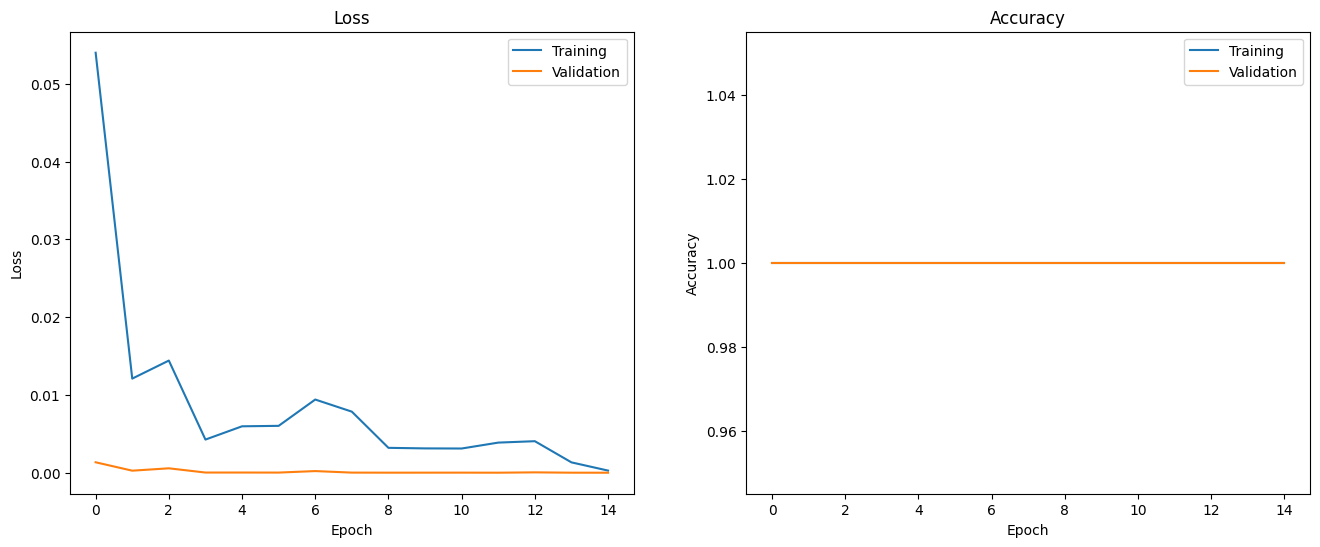

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"])
plt.plot(history["val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history["train_accuracy"])
plt.plot(history["val_accuracy"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

plt.show()

In [16]:
test_accuracy, test_predictions = calculate_accuracy(model, test_loader, device)
test_loss = validate(model, test_loader, criterion, device)
print("Test set accuracy:", test_accuracy)
print("Test loss:", test_loss)

Test set accuracy: 1.0
Test loss: 1.9484390748445436e-05


In [17]:
scripted_model = torch.jit.script(model)
scripted_model.save('./hq_unit.pt')